In [1]:
import pandas as pd
import tensorflow as tf
from keras.preprocessing import text, sequence
import numpy as np
from keras.layers import Input, SpatialDropout1D,Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, \
                            CuDNNGRU, GRU, Bidirectional, LSTM, Dense, Embedding, concatenate, Embedding, \
                            Flatten, Activation, BatchNormalization, regularizers, Conv1D

from keras.initializers import Orthogonal
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LambdaCallback, Callback, LearningRateScheduler
import keras.backend as K
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os
import pickle
import gc; gc.enable()
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords                
from nltk.stem.snowball import RussianStemmer
from scipy.stats import boxcox
#from tqdm import tqdm

E:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Check GPU Availability

In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9313005261063746220
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3174131302
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17551354236519716130
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

### Preprocess Training and Testing Data

In [3]:
# you could download it on the google drive we shared. More columns than in public kernel
agg_features_path = 'aggregated_features.csv'
train_data_path = 'train.csv'
test_data_path = 'test.csv'
embedding_file = 'cc.ru.300.vec'
seed = 411
rnn_train_epochs = 10
batch_size=128

In [4]:
agg_features = pd.read_csv(agg_features_path)
agg_cols = list(agg_features.columns)[1:]

In [5]:
train = pd.read_csv('train.csv', parse_dates=['activation_date']) \
          .sort_values('activation_date') \
          .reset_index(drop=True)
    
test = pd.read_csv('test.csv', parse_dates=['activation_date'])

In [6]:
train = train.merge(agg_features, on='user_id', how='left')
test = test.merge(agg_features, on='user_id', how='left')
del agg_features; gc.collect()

86

In [7]:
# merge to faciliate data cleaning and transformation
train_len = train.shape[0]
train_y = train.deal_probability.values

train.drop('deal_probability', axis=1, inplace=True)
all_features = pd.concat([train, test]).reset_index(drop=True)

del train, test; gc.collect()

14

#### Clean data

In [8]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

In [9]:
stemmer = RussianStemmer(ignore_stopwords=False)
def clean_text(txt):
    words = str(txt).lower().strip().split(" \t\r.,!?^+-*/@~:;/\\\"\'&{}[]()#$%") #str(txt).split(" ") #
    words = [stemmer.stem(wrd) for wrd in words \
                if wrd not in stopwords.words('russian') and len(wrd) > 1]
    txt = u" ".join(words)
    return txt

In [10]:
all_features['description'].fillna('unknowndescription', inplace=True)
all_features['description'] = [clean_text(txt) for txt in all_features['description'].values] # clean text

all_features['title'].fillna('unknowntitle', inplace=True)
all_features['title'] = all_features['title'].apply(lambda x: x.lower())

all_features['weekday'] = pd.to_datetime(all_features['activation_date']).dt.day

for col in ['description', 'title']:
    all_features['num_words_' + col] = all_features[col].apply(lambda comment: len(comment.split()))
    all_features['num_unique_words_' + col] = all_features[col].apply(lambda comment: len(set(w for w in comment.split())))

all_features['words_vs_unique_title'] = all_features['num_unique_words_title'] / all_features['num_words_title'] * 100
all_features['words_vs_unique_description'] = all_features['num_unique_words_description'] / all_features['num_words_description'] * 100
all_features['words_vs_unique_description'] = all_features['words_vs_unique_description'].fillna(0.)

all_features['city'] = all_features['region'] + '_' + all_features['city'] # city is repeated in different region
all_features['num_desc_punct'] = all_features['description'].apply(lambda x: count(x, set(string.punctuation)))

for col in agg_cols:
    all_features[col].fillna(-1, inplace=True)

for col in ['price', 'image_top_1']:
    all_features[col].fillna(-1, inplace=True)

for col in ['param_1', 'param_2', 'param_3']:
    all_features[col].fillna('unknwonparam', inplace=True)
    
for col in ['image']:
    all_features[col].fillna('no-image', inplace=True)
    
# TODO: use self train embedding for title and description separately instead of concatenating them together
all_features['description'] = all_features['title'] + ' ' + all_features['description']
all_features.drop('title', axis=1, inplace=True)

In [11]:
all_features.isnull().sum()

item_id                         0
user_id                         0
region                          0
city                            0
parent_category_name            0
category_name                   0
param_1                         0
param_2                         0
param_3                         0
description                     0
price                           0
item_seq_number                 0
activation_date                 0
user_type                       0
image                           0
image_top_1                     0
avg_days_up_user                0
avg_times_up_user               0
med_days_up_user                0
med_times_up_user               0
n_user_items                    0
weekday                         0
num_words_description           0
num_unique_words_description    0
num_words_title                 0
num_unique_words_title          0
words_vs_unique_title           0
words_vs_unique_description     0
num_desc_punct                  0
dtype: int64

#### Transform data

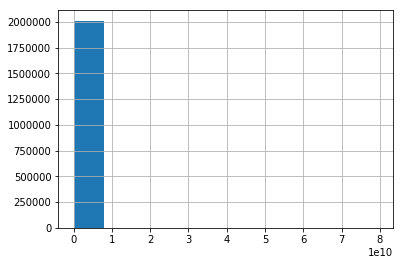

In [12]:
all_features.price.hist()

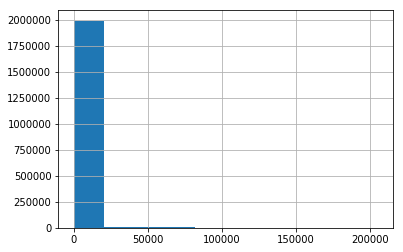

In [13]:
all_features.item_seq_number.hist()

> Since price and item seq number are highly skewed, we'll transform it into more normal like by using boxcox (more robust to outliers compared to np.log1p)

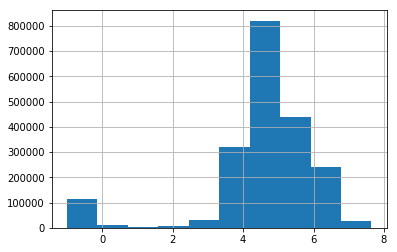

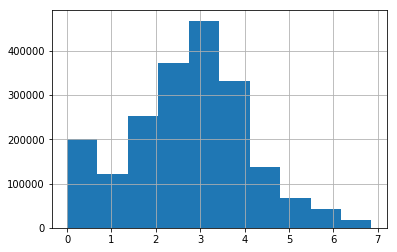

In [14]:
for col in ['price', 'item_seq_number']:
    select_filter = all_features[col] > 0
    all_features.loc[select_filter, col], _ = boxcox(all_features.loc[select_filter, col])
    all_features[col].hist()
    plt.show()

In [15]:
all_features.columns.tolist()

['item_id',
 'user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'description',
 'price',
 'item_seq_number',
 'activation_date',
 'user_type',
 'image',
 'image_top_1',
 'avg_days_up_user',
 'avg_times_up_user',
 'med_days_up_user',
 'med_times_up_user',
 'n_user_items',
 'weekday',
 'num_words_description',
 'num_unique_words_description',
 'num_words_title',
 'num_unique_words_title',
 'words_vs_unique_title',
 'words_vs_unique_description',
 'num_desc_punct']

In [16]:
target = 'deal_probability'
numerical = [
    'weekday', 'num_words_title', 'num_words_description',
    'num_unique_words_title', 'num_unique_words_description',
    'words_vs_unique_title', 'words_vs_unique_description',
    'num_desc_punct', 'avg_times_up_user', 'avg_days_up_user', 
    'med_times_up_user', 'med_days_up_user', 'n_user_items', 
    'price', 'item_seq_number'
]

categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

features = numerical+categorical

In [17]:
# label encode categorical data
from sklearn.preprocessing import LabelEncoder

for feature in categorical:
    print('Transforming {}...'.format(feature))
    encoder = LabelEncoder()
    all_features.loc[:, feature] = encoder.fit_transform(all_features[feature].astype(str))

Transforming image_top_1...
Transforming param_1...
Transforming param_2...
Transforming param_3...
Transforming city...
Transforming region...
Transforming category_name...
Transforming parent_category_name...
Transforming user_type...


In [18]:
# standardize numerical data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_features.loc[:, numerical] = scaler.fit_transform(all_features[numerical].values)

#### Prepare  pre-trained embeddings and text

In [19]:
max_features = 200000
maxlen = 150
embed_size = 300

In [20]:
texts = all_features.description.values

In [21]:
print('fitting tokenizer')
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)

fitting tokenizer


In [22]:
print('getting embeddings')
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding = 'utf8'))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

getting embeddings


In [23]:
print('setup max info for embedding in categorical variables')
max_info = dict((col, all_features[col].max()+1) for col in categorical)

setup max info for embedding in categorical variables


In [24]:
print('convert to sequences')
texts = tokenizer.texts_to_sequences(texts)

convert to sequences


In [25]:
print('padding')
texts = sequence.pad_sequences(texts, maxlen=maxlen)

padding


### Build RNN Model

In [26]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [27]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        print(input_shape)
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [28]:
def clip_rmse(true, prediction):
    return np.sqrt(metrics.mean_squared_error(true, np.clip(prediction, 0., 1.)))
    
class NBatchEvalLogger(Callback):
    def __init__(self, display, val_X, val_y, save_path=None, save_start=1000):
        self.step = 0
        self.display = display
        self.val_X = val_X
        self.val_y = val_y
        self.best_loss = None
        self.save_path = save_path
        self.save_start = save_start
        self.record_count = 0
        
    def on_batch_end(self, batch, logs={}):
        self.step += 1
        if self.step % self.display == 0 and self.step >= self.save_start:
            #loss, metric = self.model.evaluate(self.val_X, self.val_y, batch_size=128, verbose=1)
            prediction = self.model.predict(self.val_X, batch_size=128, verbose=0)
            loss = clip_rmse(self.val_y, prediction)
            
            if self.best_loss is None:
                self.best_loss = loss
            else:
                if loss < self.best_loss:
                    self.best_loss = loss
                    if self.save_path is not None:
                        self.model.save(self.save_path, overwrite=True)
                        self.record_count += 1
                    
            print('\rstep: {} val loss={:.5f}, best loss={:.5f}'.format(self.step, loss, self.best_loss))

In [29]:
import keras
from copy import deepcopy as cp

class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
    def __init__(self, list_IDs, X, y, batch_size=32, shuffle=True, is_train=True, img_path=None):
        #'Initialization'
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.img_path = img_path
        self.is_train = is_train
        self.on_epoch_end()

    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        #'Generate one batch of data'
        # Generate indexes of the batch
        start = index*self.batch_size
        end = min((index+1)*self.batch_size, len(self.indexes))
        indexes = self.indexes[start: end]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = cp(list(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Generate data
        X = dict((col, self.X.loc[list_IDs_temp, col].values) for col in features)
        X['text'] = texts[list_IDs_temp,:]
        
        # add img data
        for image_name in self.X.loc[list_IDs_temp, 'image'].values:
            if image_name == 'no-image':
                pass #TODO: all-zero image
            else:
                pass #TODO: load real image
        
        if self.is_train:
            y = cp(self.y[list_IDs_temp])
            return X, y
        else:
            return X

In [30]:
def build_model(X, categorical_features, numerical_features):
    
    # non-cat features
    non_cat_inputs = []
    for col in numerical_features:
        f = Input(shape=[1], name=col)
        non_cat_inputs.append(f)
        
    # cat features
    cat_inputs = []
    cat_embeds = []
    for col in categorical_features:
        f = Input(shape=[1], name=col)
        embed_dim = max_info[col].max()+1
        if max_info[col].max() > 10:
            reduced_dim = 10
        else:
            reduced_dim = 1
        embed_f = Embedding(embed_dim, reduced_dim)(f)
        flatten_f = Flatten()(embed_f)
        cat_inputs.append(f)
        cat_embeds.append(flatten_f)
      
    # text features: architecture of text to try here!!!
    text_inp = Input(shape = (maxlen, ), name='text')
    
    text_emb = Embedding(nb_words, embed_size, weights = [embedding_matrix],
                    input_length = maxlen, trainable = False)(text_inp)
    text_emb = SpatialDropout1D(0.3)(text_emb)
    
    text_gru = CuDNNGRU(128, return_sequences=True)(text_emb)
    text_gru = CuDNNGRU(64)(text_gru)
    text_gru = Dropout(0.1)(text_gru)
    
    #text_gru = Bidirectional(CuDNNGRU(64, return_sequences = True))(text_emb)
    #text_gru = Attention(maxlen)(text_gru)
    #text_gru = Conv1D(32, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(text_gru)
    #text_gru_avg = GlobalAveragePooling1D()(text_gru)
    #text_gru_max = GlobalMaxPooling1D()(text_gru)
    #text_gru = concatenate([text_gru_avg, text_gru_max]) 
    #text_gru = Dropout(0.1)(text_gru)
    
    # add image architecture ???
    
    # merge each branch: non-cat, cat, text
    concat_main = non_cat_inputs+cat_embeds+[text_gru]
    main = concatenate(concat_main)
    main = BatchNormalization()(main)
    main = Dropout(0.1)(main)
    main = BatchNormalization()(Dense(512, activation='relu')(main))
    main = Dropout(0.1)(main)
    main = BatchNormalization()(Dense(64, activation='relu')(main))
    out = Dense(1, activation = "sigmoid")(main)

    concat_input = non_cat_inputs+cat_inputs+[text_inp]
    model = Model(concat_input, out)
    model.regularizers = [regularizers.l2(0.0001)]
    model.compile(optimizer = Adam(lr=0.001), loss = root_mean_squared_error,
                  metrics =[root_mean_squared_error])
    model.summary()
    return model

### Training

In [31]:
from sklearn.model_selection import KFold
import warnings; warnings.filterwarnings('ignore') 

In [32]:
train_indices = np.arange(0, train_len)
test_indices = np.arange(train_len, all_features.shape[0])

In [33]:
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress

In [34]:
fold = 0
ret = np.zeros((train_len,))
ret_test = np.zeros((all_features.shape[0]-train_len,))

for tr_ix, val_ix in KFold(5, shuffle=True, random_state=seed).split(train_indices):
    fold += 1
    
    model = build_model(all_features, categorical, numerical)
    file_path = "rnn_weights/model_fold_{}.hdf5".format(fold)
    
    # old style
    '''
    X_train = dict((col, all_features.loc[tr_ix, col].values) for col in features)
    X_train['text'] = texts[tr_ix,:]
    y_train = train_y[tr_ix]
    X_val = dict((col, all_features.loc[val_ix, col].values) for col in features)
    X_val['text'] = texts[val_ix,:]
    y_val = train_y[val_ix]
    
    lr_schd = LearningRateScheduler(lambda epoch: 0.001*(0.2**(epoch//8)), verbose=1)
    check_point = NBatchEvalLogger(2000, X_val, y_val, save_path=file_path, save_start=2000)
    #check_point = ModelCheckpoint(file_path, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
    
    history = model.fit(X_train, y_train, batch_size = 128, epochs = rnn_train_epochs, validation_data = (X_val, y_val),
                    verbose = 0, callbacks = [lr_schd, check_point, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
    
    del model, X_train, y_train, X_val, y_val, history; gc.collect()
    '''

    # customized batch loader
    training_generator = DataGenerator(tr_ix, all_features, train_y, batch_size=batch_size, shuffle=True)
    validation_generator = DataGenerator(val_ix, all_features, train_y, batch_size=batch_size, shuffle=False)

    lr_schd = LearningRateScheduler(lambda epoch: 0.001*(0.2**(epoch//7)), verbose=1)
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
    history = model.fit_generator(generator=training_generator,
                                  validation_data=validation_generator,
                                  use_multiprocessing=False,
                                  workers=1, 
                                  epochs=rnn_train_epochs,
                                  verbose = 0, 
                                  callbacks = [lr_schd, check_point, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
    
    
    # Predict val + test oofs
    model.load_weights(file_path) # load weight with best validation score
    
    del validation_generator
    validation_generator = DataGenerator(val_ix, all_features, None, batch_size=batch_size, shuffle=False, is_train=False)
    test_generator = DataGenerator(test_indices, all_features, None, batch_size=batch_size, shuffle=False, is_train=False)
    
    ret[val_ix] = model.predict_generator(validation_generator, use_multiprocessing=False, workers=1).reshape((len(val_ix),))
    ret_test += model.predict_generator(test_generator, use_multiprocessing=False, workers=1).reshape((ret_test.shape[0],))
    
    del model, history, training_generator, validation_generator, test_generator; gc.collect()
    
ret_test /= 5

Instructions for updating:
Use the retry module or similar alternatives.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 150, 300)     60000000    text[0][0]                       
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 150, 300)     0           embedding_10[0][0]               
__________________________________________________________________________________________________
image_top_1 (InputLayer)        (None, 1)            0                                            
____________________________________


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00001: val_loss improved from inf to 0.22470, saving model to rnn_weights/model_fold_1.hdf5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00002: val_loss improved from 0.22470 to 0.22243, saving model to rnn_weights/model_fold_1.hdf5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00003: val_loss improved from 0.22243 to 0.22124, saving model to rnn_weights/model_fold_1.hdf5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00004: val_loss improved from 0.22124 to 0.22081, saving model to rnn_weights/model_fold_1.hdf5

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00005: val_loss improved from 0.22081 to 0.22003, saving model to rnn_weights/model_fold_1.hdf5

Epoch 00006: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00006: val_loss improved from 0.22003 to 0.21968, saving model to rnn_weights/model_fold_1.hdf5

Epoch 00007: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00007: val_loss improved from 0.21968 to 0.21942, saving model to rnn_weights/model_fold_1.hdf5

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00008: val_loss improved from 0.21942 to 0.21900, saving model to rnn_weights/model_fold_1.hdf5

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00009: val_loss did not improve from 0.21900

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00010: val_loss did not improve from 0.21900

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 150, 300)     60000000    text[0][0]                       
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 150, 300)     0           embedding_20[0][0]               
__________________________________________________________________________________________________
image_top_1 (InputLayer)        (None, 1)            0                                            
________________________________________________________


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00001: val_loss improved from inf to 0.22700, saving model to rnn_weights/model_fold_2.hdf5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00002: val_loss improved from 0.22700 to 0.22478, saving model to rnn_weights/model_fold_2.hdf5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00003: val_loss improved from 0.22478 to 0.22154, saving model to rnn_weights/model_fold_2.hdf5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00004: val_loss did not improve from 0.22154

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00005: val_loss improved from 0.22154 to 0.22048, saving model to rnn_weights/model_fold_2.hdf5

Epoch 00006: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00006: val_loss did not improve from 0.22048

Epoch 00007: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00007: val_loss improved from 0.22048 to 0.22015, saving model to rnn_weights/model_fold_2.hdf5

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00008: val_loss improved from 0.22015 to 0.21939, saving model to rnn_weights/model_fold_2.hdf5

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00009: val_loss did not improve from 0.21939

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00010: val_loss improved from 0.21939 to 0.21926, saving model to rnn_weights/model_fold_2.hdf5

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 150, 300)     60000000    text[0][0]                       
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 150, 300)     0           embedding_30[0][0]               
__________________________________________________________________________________________________
image_top_1 (InputLayer)        (None, 1)            0                                            
_____


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00001: val_loss improved from inf to 0.22461, saving model to rnn_weights/model_fold_3.hdf5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00002: val_loss improved from 0.22461 to 0.22379, saving model to rnn_weights/model_fold_3.hdf5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00003: val_loss improved from 0.22379 to 0.22294, saving model to rnn_weights/model_fold_3.hdf5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00004: val_loss improved from 0.22294 to 0.22134, saving model to rnn_weights/model_fold_3.hdf5

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00005: val_loss did not improve from 0.22134

Epoch 00006: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00006: val_loss improved from 0.22134 to 0.22015, saving model to rnn_weights/model_fold_3.hdf5

Epoch 00007: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00007: val_loss improved from 0.22015 to 0.22001, saving model to rnn_weights/model_fold_3.hdf5

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00008: val_loss improved from 0.22001 to 0.21889, saving model to rnn_weights/model_fold_3.hdf5

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00009: val_loss improved from 0.21889 to 0.21848, saving model to rnn_weights/model_fold_3.hdf5

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00010: val_loss did not improve from 0.21848

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, 150, 300)     60000000    text[0][0]                       
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 150, 300)     0           embedding_40[0][0]               
__________________________________________________________________________________________________
image_top_1 (InputLayer)        (None, 1)            0                                            
________________________________________________________


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00001: val_loss improved from inf to 0.22388, saving model to rnn_weights/model_fold_4.hdf5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00002: val_loss improved from 0.22388 to 0.22140, saving model to rnn_weights/model_fold_4.hdf5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00003: val_loss improved from 0.22140 to 0.22031, saving model to rnn_weights/model_fold_4.hdf5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00004: val_loss improved from 0.22031 to 0.21914, saving model to rnn_weights/model_fold_4.hdf5

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00005: val_loss did not improve from 0.21914

Epoch 00006: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00006: val_loss improved from 0.21914 to 0.21861, saving model to rnn_weights/model_fold_4.hdf5

Epoch 00007: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00007: val_loss did not improve from 0.21861

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00008: val_loss improved from 0.21861 to 0.21832, saving model to rnn_weights/model_fold_4.hdf5

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00009: val_loss did not improve from 0.21832

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00010: val_loss did not improve from 0.21832

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_50 (Embedding)        (None, 150, 300)     60000000    text[0][0]                       
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 150, 300)     0           embedding_50[0][0]               
__________________________________________________________________________________________________
image_top_1 (InputLayer)        (None, 1)            0                                            
________________________________________________________


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00001: val_loss improved from inf to 0.22470, saving model to rnn_weights/model_fold_5.hdf5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00002: val_loss improved from 0.22470 to 0.22249, saving model to rnn_weights/model_fold_5.hdf5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00003: val_loss improved from 0.22249 to 0.22119, saving model to rnn_weights/model_fold_5.hdf5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00004: val_loss improved from 0.22119 to 0.22038, saving model to rnn_weights/model_fold_5.hdf5

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00005: val_loss did not improve from 0.22038

Epoch 00006: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00006: val_loss improved from 0.22038 to 0.22011, saving model to rnn_weights/model_fold_5.hdf5

Epoch 00007: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00007: val_loss improved from 0.22011 to 0.21986, saving model to rnn_weights/model_fold_5.hdf5

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00008: val_loss improved from 0.21986 to 0.21908, saving model to rnn_weights/model_fold_5.hdf5

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00009: val_loss did not improve from 0.21908

Epoch 00010: LearningRateScheduler reducing learning rate to 0.0002.



Epoch 00010: val_loss improved from 0.21908 to 0.21908, saving model to rnn_weights/model_fold_5.hdf5



In [35]:
# public:  cv = .2220, lb = .2247 
# bigru-conv1d: cv =.2185 , lb = .2235
# bigru-attention: cv =.2186 , lb = .2235

### Generate OOFs and Submissions

In [36]:
pd.DataFrame(data=ret, columns=['pretrained_2gru_rnn_pred']).to_csv('pretrained_2gru_rnn_oof_val_pred.csv', index=False)
pd.DataFrame(data=ret_test, columns=['pretrained_2gru_rnn_pred']).to_csv('pretrained_2gru_rnn_oof_test_pred.csv', index=False)

In [37]:
subm = pd.read_csv('sample_submission.csv')
subm['deal_probability'] = np.clip(ret_test, 0, 1)
subm.to_csv('pretrained_2gru_rnn_submission.csv', index=False)